# Download Dataset

In [1]:
# install kaggle package
!pip install -q kaggle

In [2]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"irasalsabila","key":"589a4505738e7e8a157046eb8ea792b9"}'}

In [3]:
# check dataset list
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              233KB  2021-07-07 19:18:09           9092  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           5557  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2013  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2392  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [4]:
# download dataset
!kaggle datasets download -d hgultekin/bbcnewsarchive

  0% 0.00/1.81M [00:00<?, ?B/s]
100% 1.81M/1.81M [00:00<00:00, 58.8MB/s]


In [5]:
# unzip dataset
!mkdir bbcnewsarchive
!unzip bbcnewsarchive.zip -d bbcnewsarchive
!ls bbcnewsarchive

Archive:  bbcnewsarchive.zip
  inflating: bbcnewsarchive/bbc-news-data.csv  
bbc-news-data.csv


# Load Dataset

In [6]:
# libraries
import pandas as pd
import nltk, os, re, string
import tensorflow as tf

from tensorflow.keras.layers import Input, LSTM, Bidirectional, SpatialDropout1D, Dropout, Flatten, Dense, Embedding, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
# load dataset
df = pd.read_csv('bbcnewsarchive/bbc-news-data.csv', sep='\t')
df.head(10)

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
5,business,006.txt,Japan narrowly escapes recession,Japan's economy teetered on the brink of a te...
6,business,007.txt,Jobs growth still slow in the US,The US created fewer jobs than expected in Ja...
7,business,008.txt,India calls for fair trade rules,"India, which attends the G7 meeting of seven ..."
8,business,009.txt,Ethiopia's crop production up 24%,Ethiopia produced 14.27 million tonnes of cro...
9,business,010.txt,Court rejects $280bn tobacco case,A US government claim accusing the country's ...


In [8]:
print(df.columns)
print(df.shape)
print(df.info())

Index(['category', 'filename', 'title', 'content'], dtype='object')
(2225, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB
None


In [9]:
# categories
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [10]:
# delete unused columns
df = df.drop(columns = ['filename'])
df.head(5)

,category,title,content
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


# Cleansing Data

In [11]:
# lowercasing
df.title = df.title.apply(lambda x: x.lower())
df.content = df.content.apply(lambda x: x.lower())

In [12]:
# removing functuation
def cleaner(data):
    return(data.translate(str.maketrans('','', string.punctuation)))
    df.title = df.title.apply(lambda x: cleaner(x))
    df.content = df.content.apply(lambda x: lem(x))

In [13]:
# lematization
lemmatizer = WordNetLemmatizer()

def lem(data):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(data.split())]))
    df.title = df.title.apply(lambda x: lem(x))
    df.content = df.content.apply(lambda x: lem(x))

In [14]:
# removing number
def rem_numbers(data):
    return re.sub('[0-9]+','',data)
    df['title'].apply(rem_numbers)
    df['content'].apply(rem_numbers)

In [15]:
# removing stopword
st_words = stopwords.words()
def stopword(data):
    return(' '.join([w for w in data.split() if w not in st_words ]))
    df.title = df.title.apply(lambda x: stopword(x))
    df.content = df.content.apply(lambda x: lem(x))

In [16]:
# view data
df.head(10)

,category,title,content
0,business,ad sales boost time warner profit,quarterly profits at us media giant timewarne...
1,business,dollar gains on greenspan speech,the dollar has hit its highest level against ...
2,business,yukos unit buyer faces loan claim,the owners of embattled russian oil giant yuk...
3,business,high fuel prices hit ba's profits,british airways has blamed high fuel prices f...
4,business,pernod takeover talk lifts domecq,shares in uk drinks and food firm allied dome...
5,business,japan narrowly escapes recession,japan's economy teetered on the brink of a te...
6,business,jobs growth still slow in the us,the us created fewer jobs than expected in ja...
7,business,india calls for fair trade rules,"india, which attends the g7 meeting of seven ..."
8,business,ethiopia's crop production up 24%,ethiopia produced 14.27 million tonnes of cro...
9,business,court rejects $280bn tobacco case,a us government claim accusing the country's ...


In [17]:
# one-hot-encoding
category = pd.get_dummies(df.category)
df = pd.concat([df, category], axis = 1)
df = df.drop(columns = 'category')
df.head(10)

,title,content,business,entertainment,politics,sport,tech
0,ad sales boost time warner profit,quarterly profits at us media giant timewarne...,1,0,0,0,0
1,dollar gains on greenspan speech,the dollar has hit its highest level against ...,1,0,0,0,0
2,yukos unit buyer faces loan claim,the owners of embattled russian oil giant yuk...,1,0,0,0,0
3,high fuel prices hit ba's profits,british airways has blamed high fuel prices f...,1,0,0,0,0
4,pernod takeover talk lifts domecq,shares in uk drinks and food firm allied dome...,1,0,0,0,0
5,japan narrowly escapes recession,japan's economy teetered on the brink of a te...,1,0,0,0,0
6,jobs growth still slow in the us,the us created fewer jobs than expected in ja...,1,0,0,0,0
7,india calls for fair trade rules,"india, which attends the g7 meeting of seven ...",1,0,0,0,0
8,ethiopia's crop production up 24%,ethiopia produced 14.27 million tonnes of cro...,1,0,0,0,0
9,court rejects $280bn tobacco case,a us government claim accusing the country's ...,1,0,0,0,0


In [18]:
# change value to numpy array
news = df['title'].values + '' + df['content'].values
label = df[['business', 'entertainment', 'politics', 'sport', 'tech']].values

In [50]:
# view label
label

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]], dtype=uint8)

In [72]:
# Split data
news_train, news_test, label_train, label_test = train_test_split(news, label, test_size=0.2, shuffle=True)

In [73]:
# tokenizer
 
tokenizer = Tokenizer(num_words=2000, oov_token='x', filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~ ')
tokenizer.fit_on_texts(news_train) 
tokenizer.fit_on_texts(news_test)
 
sekuens_train = tokenizer.texts_to_sequences(news_train)
sekuens_test = tokenizer.texts_to_sequences(news_test)
 
padded_train = pad_sequences(sekuens_train) 
padded_test = pad_sequences(sekuens_test)

In [75]:
# model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy',)
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 64)          320000    
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_47 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_34 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 5)               

In [76]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90 and logs.get('val_accuracy')>0.85):
      self.model.stop_training = True
      print("\nThe accuracy of the training set has reached > 90% and the validation set has reached > 85%!")
callbacks = myCallback()

In [77]:
# model fit
history = model.fit(padded_train, label_train, epochs = 30, 
                    validation_data = (padded_test, label_test), 
                    verbose = 1, callbacks = [callbacks], validation_steps = 20)

Epoch 1/30
56/56 [==============================] - 34s 568ms/step - loss: 1.6065 - accuracy: 0.2225 - val_loss: 1.5872 - val_accuracy: 0.2517
Epoch 2/30
56/56 [==============================] - 31s 558ms/step - loss: 1.5631 - accuracy: 0.3045 - val_loss: 1.3572 - val_accuracy: 0.3618
Epoch 3/30
56/56 [==============================] - 31s 554ms/step - loss: 1.2231 - accuracy: 0.4927 - val_loss: 0.8854 - val_accuracy: 0.6225
Epoch 4/30
56/56 [==============================] - 31s 551ms/step - loss: 0.7935 - accuracy: 0.6843 - val_loss: 0.6978 - val_accuracy: 0.7640
Epoch 5/30
56/56 [==============================] - 31s 552ms/step - loss: 0.4911 - accuracy: 0.8337 - val_loss: 0.6636 - val_accuracy: 0.7528
Epoch 6/30
56/56 [==============================] - 31s 549ms/step - loss: 0.2695 - accuracy: 0.9180 - val_loss: 0.4902 - val_accuracy: 0.8517

The accuracy of the training set has reached > 90% and the validation set has reached > 85%!


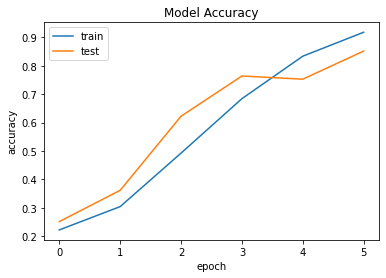

In [78]:
# plot of accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

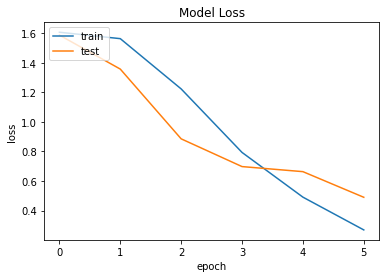

In [79]:
# plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()